In [ ]:
# Import delle librerie utili

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('dataset_azienda.csv')
df.head()

Saving dataset_azienda.csv to dataset_azienda (1).csv


,Date,1,2,3
0,2018-01-04,72.45,4.45,75.89
1,2018-01-05,0.00,5.28,0.00
2,2018-01-06,0.00,0.00,0.00
3,2018-01-07,95.38,2.34,71.37
4,2018-01-08,0.00,0.00,0.00


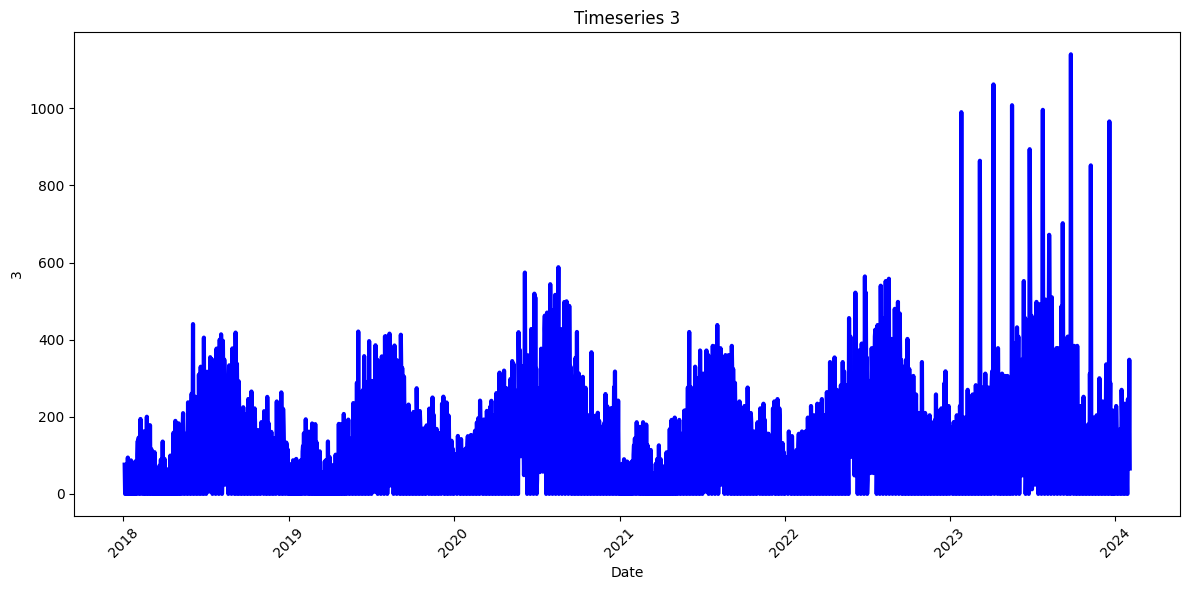

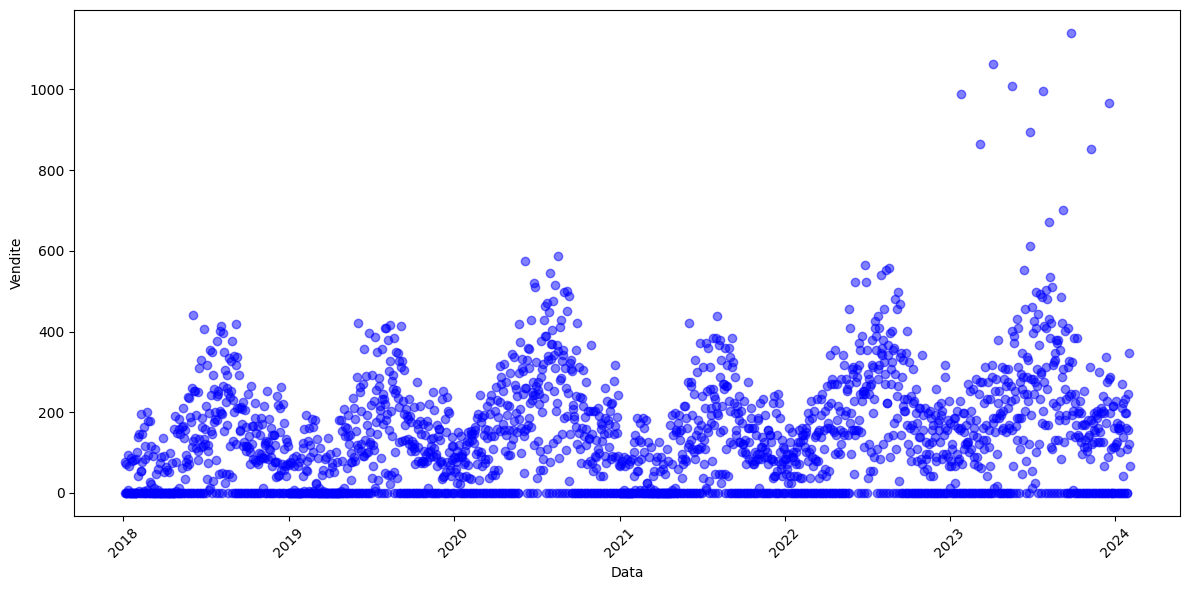

Frequenza dell'indice: <Day>
Colonne dopo la rinomina per Prophet: ['ds', 'y']
          ds      y
0 2018-01-04  75.89
1 2018-01-05   0.00
2 2018-01-06   0.00
3 2018-01-07  71.37
4 2018-01-08   0.00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converti la colonna Datetime in DateTimeIndex e ordina i dati
df['Date'] = pd.to_datetime(df['Date'])
df_sorted = df.sort_values(by='Date').reset_index(drop=True)

# Seleziona le colonne di interesse
df_timeseries_3 = df_sorted[['Date', '3']]

# Plot della serie temporale
plt.figure(figsize=(12, 6))
plt.plot(df_sorted['Date'], df_sorted['3'], linewidth=3, c='blue')
plt.title("Timeseries 3")
plt.xlabel("Date")
plt.ylabel("3")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter plot della serie temporale
plt.figure(figsize=(12, 6))
plt.scatter(df_sorted['Date'], df_sorted['3'], c='blue', marker='o', alpha=0.5)
plt.xlabel("Data")
plt.ylabel("Vendite")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prepara i dati per Prophet
df_prophet = df_timeseries_3.copy()

# Imposta la colonna 'Date' come indice
df_timeseries_3.set_index('Date', inplace=True)

# Assicurati che l'indice sia un DatetimeIndex
df_timeseries_3.index = pd.to_datetime(df_timeseries_3.index, errors='coerce')

# Imposta la frequenza dell'indice
df_timeseries_3 = df_timeseries_3.asfreq('D')
print(f"Frequenza dell'indice: {df_timeseries_3.index.freq}")

# Assegna la colonna '3' alla variabile y
y = df_timeseries_3['3']

# Crea una copia del dataset originale utile per il modello Prophet
df_prophet_ts3 = df_prophet
# Rinomina le colonne per Prophet
df_prophet_ts3 = df_prophet_ts3.rename(columns={'Date': 'ds', '3': 'y'})

# Verifica che la rinomina sia avvenuta correttamente
print("Colonne dopo la rinomina per Prophet:", df_prophet_ts3.columns.tolist())

# Verifica il risultato finale
print(df_prophet_ts3.head())

# Outliers


In [ ]:
import pandas as pd

# Filtra solo i dati del 2023 usando l'indice invece della colonna 'Date' per df_timeseries_3
df_2023 = df_timeseries_3[df_timeseries_3.index.year == 2023].copy()

# Calcolo dei quartili e dell'Interquartile Range (IQR)
Q1 = df_2023['3'].quantile(0.25)
Q3 = df_2023['3'].quantile(0.75)
IQR = Q3 - Q1

# Definizione dei limiti accettabili
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calcolo della mediana dei valori accettabili
median_value = df_2023[(df_2023['3'] >= lower_bound) & (df_2023['3'] <= upper_bound)]['3'].median()

# Sostituisce gli outliers con la mediana
df_2023.loc[(df_2023['3'] < lower_bound) | (df_2023['3'] > upper_bound), '3'] = median_value

# Unisce i dati modificati del 2023 con il resto del dataset
df_cleaned = pd.concat([df_timeseries_3[df_timeseries_3.index.year != 2023], df_2023])

# Ordina il dataframe per data
df_cleaned = df_cleaned.sort_index()

# Mostra il numero di outliers sostituiti
print(f"Outliers sostituiti in df_timeseries_3: {(df_2023['3'] < lower_bound).sum() + (df_2023['3'] > upper_bound).sum()}")

# ------ PULIZIA DEL DATAFRAME PER PROPHET ------

# Filtra solo i dati del 2023 per df_prophet_ts3
df_2023_prophet = df_prophet_ts3[df_prophet_ts3['ds'].dt.year == 2023].copy()

# Calcolo dei quartili e dell'Interquartile Range (IQR)
Q1_p = df_2023_prophet['y'].quantile(0.25)
Q3_p = df_2023_prophet['y'].quantile(0.75)
IQR_p = Q3_p - Q1_p

# Definizione dei limiti accettabili
lower_bound_p = Q1_p - 1.5 * IQR_p
upper_bound_p = Q3_p + 1.5 * IQR_p

# Calcolo della mediana dei valori accettabili
median_value_p = df_2023_prophet[(df_2023_prophet['y'] >= lower_bound_p) & (df_2023_prophet['y'] <= upper_bound_p)]['y'].median()

# Sostituisce gli outliers con la mediana
df_2023_prophet['y'] = df_2023_prophet['y'].apply(lambda x: median_value_p if x < lower_bound_p or x > upper_bound_p else x)

# Unisce i dati modificati del 2023 con il resto del dataset
df_prophet_ts3_cleaned = pd.concat([df_prophet_ts3[df_prophet_ts3['ds'].dt.year != 2023], df_2023_prophet])

# Ordina il dataframe per data
df_prophet_ts3_cleaned = df_prophet_ts3_cleaned.sort_values(by='ds')

# Mostra quanti outliers sono stati sostituiti
outliers_count_p = sum((df_2023_prophet['y'] < lower_bound_p) | (df_2023_prophet['y'] > upper_bound_p))
print(f"Outliers sostituiti in df_prophet_ts3: {outliers_count_p}")


Outliers sostituiti in df_timeseries_3: 0
Outliers sostituiti in df_prophet_ts3: 0


In [ ]:
y = df_cleaned['3']

# Modelli

In [ ]:
pip install prophet --no-binary :all:

In [ ]:
!pip install prophet

In [ ]:
pip install pmdarima

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

HW - Fold 1: RMSE=112.89, MAE=90.57, MAPE=inf, MASE=0.9215
------------------------------
ARIMA - Fold 1: RMSE=113.92, MAE=87.37, MAPE=inf, MASE=0.8889
------------------------------
SARIMA - Fold 1: RMSE=222.84, MAE=180.04, MAPE=inf, MASE=1.8318
------------------------------


<ipython-input-46-a138dbb29060>:54: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(test_prophet['y'].values - forecast_prophet) / test_prophet['y'].values).mean() * 100
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Prophet - Fold 1: RMSE=114.12, MAE=92.88, MAPE=inf, MASE=0.9450
------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w9xerw7/940tcqnd.json


HW - Fold 2: RMSE=161.46, MAE=123.65, MAPE=inf, MASE=1.2546
------------------------------
ARIMA - Fold 2: RMSE=162.34, MAE=123.11, MAPE=inf, MASE=1.2491
------------------------------
SARIMA - Fold 2: RMSE=216.31, MAE=166.46, MAPE=inf, MASE=1.6889
------------------------------


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w9xerw7/zgir84j4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48496', 'data', 'file=/tmp/tmp_w9xerw7/940tcqnd.json', 'init=/tmp/tmp_w9xerw7/zgir84j4.json', 'output', 'file=/tmp/tmp_w9xerw7/prophet_modelluyhgohm/prophet_model-20250309202511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-46-a138dbb29060>:54: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(test_prophet['y'].values - forecast_prophet) / test_prophet['y'].values).mean() * 100
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informatio

Prophet - Fold 2: RMSE=148.22, MAE=121.40, MAPE=inf, MASE=1.2317
------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w9xerw7/calbhb17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w9xerw7/cjfaik26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69365', 'data', 'file=/tmp/tmp_w9xerw7/calbhb17.json', 'init=/tmp/tmp_w9xerw7/cjfaik26.json', 'output', 'file=/tmp/tmp_w9xerw7/prophet_model55w3gsir/prophet_model-20250309202722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:27:22 - cmdstanpy - INFO - Chai

HW - Fold 3: RMSE=106.44, MAE=89.26, MAPE=inf, MASE=0.7551
------------------------------
ARIMA - Fold 3: RMSE=124.77, MAE=104.55, MAPE=inf, MASE=0.8845
------------------------------
SARIMA - Fold 3: RMSE=130.62, MAE=106.49, MAPE=inf, MASE=0.9008
------------------------------


20:27:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-46-a138dbb29060>:54: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(test_prophet['y'].values - forecast_prophet) / test_prophet['y'].values).mean() * 100
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Prophet - Fold 3: RMSE=140.74, MAE=111.09, MAPE=inf, MASE=0.9398
------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

HW - Fold 4: RMSE=149.31, MAE=116.58, MAPE=inf, MASE=1.0295
------------------------------
ARIMA - Fold 4: RMSE=143.56, MAE=103.69, MAPE=inf, MASE=0.9156
------------------------------
SARIMA - Fold 4: RMSE=152.11, MAE=110.74, MAPE=inf, MASE=0.9779
------------------------------


20:30:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-46-a138dbb29060>:54: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(test_prophet['y'].values - forecast_prophet) / test_prophet['y'].values).mean() * 100
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Prophet - Fold 4: RMSE=147.25, MAE=119.53, MAPE=inf, MASE=1.0555
------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

HW - Fold 5: RMSE=140.38, MAE=112.15, MAPE=inf, MASE=0.9189
------------------------------
ARIMA - Fold 5: RMSE=114.84, MAE=79.74, MAPE=inf, MASE=0.6533
------------------------------
SARIMA - Fold 5: RMSE=127.99, MAE=94.86, MAPE=inf, MASE=0.7772
------------------------------


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w9xerw7/hr5_u28e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54097', 'data', 'file=/tmp/tmp_w9xerw7/_4ucqdot.json', 'init=/tmp/tmp_w9xerw7/hr5_u28e.json', 'output', 'file=/tmp/tmp_w9xerw7/prophet_model7l72fe0e/prophet_model-20250309203301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-46-a138dbb29060>:54: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(test_prophet['y'].values - forecast_prophet) / test_prophet['y'].values).mean() * 100


Prophet - Fold 5: RMSE=108.28, MAE=88.09, MAPE=inf, MASE=0.7217
------------------------------


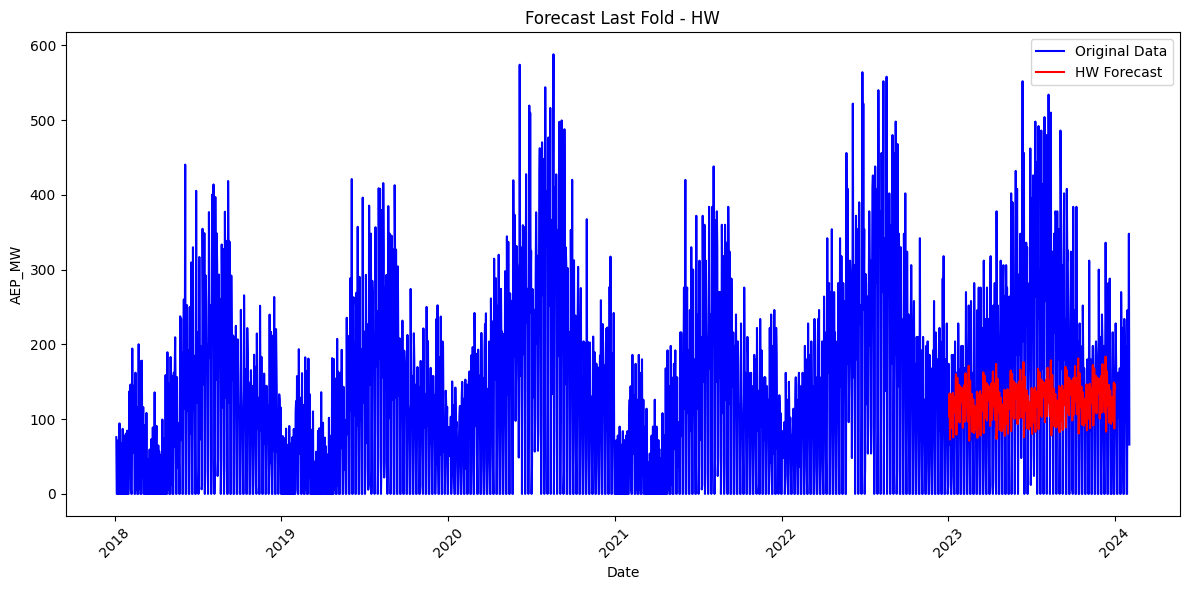

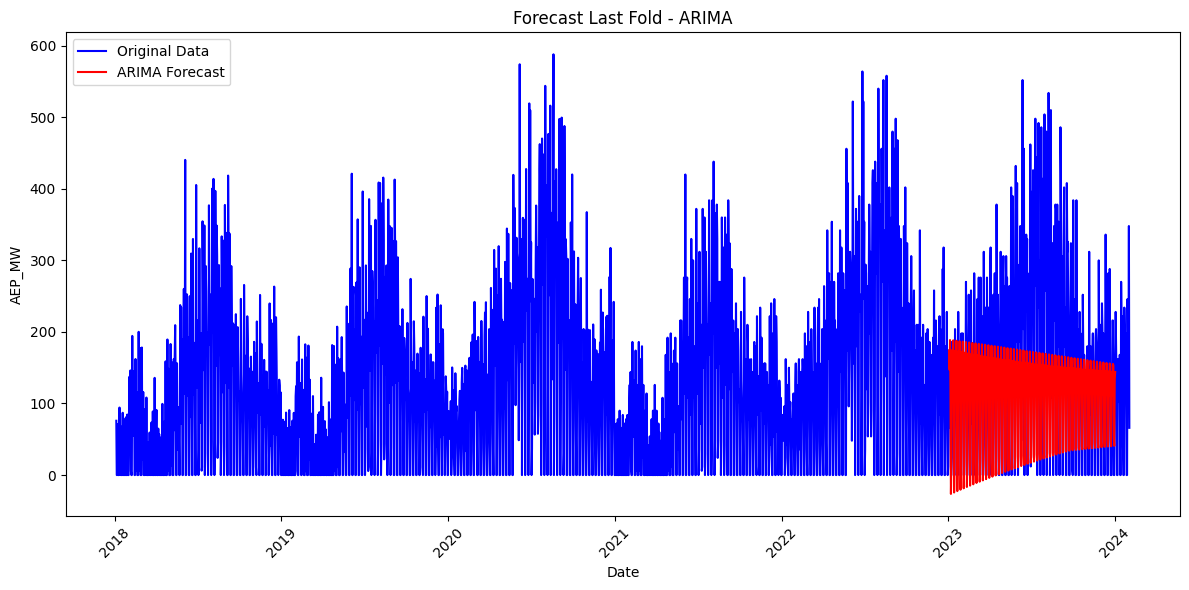

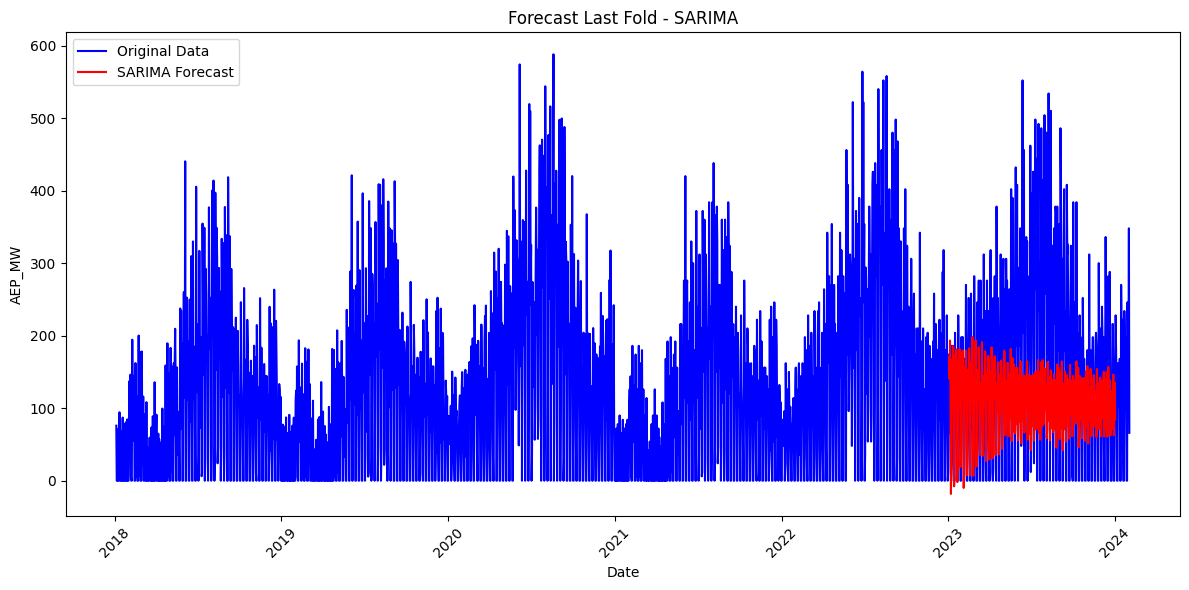

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w9xerw7/rrvkm5b9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w9xerw7/1v3fh1fi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32138', 'data', 'file=/tmp/tmp_w9xerw7/rrvkm5b9.json', 'init=/tmp/tmp_w9xerw7/1v3fh1fi.json', 'output', 'file=/tmp/tmp_w9xerw7/prophet_model98ign4ef/prophet_model-20250309203302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:33:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


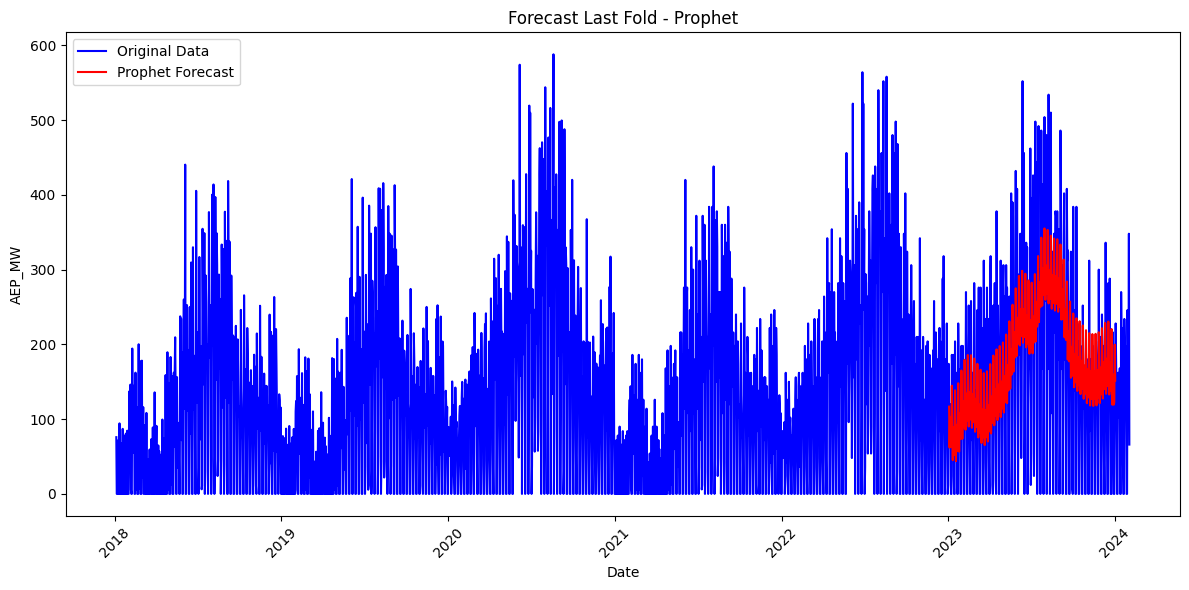

 
HW - Media: RMSE=134.10, MAE=106.44, MAPE=inf, MASE=0.9759
HW - Mediana: RMSE=140.38, MAE=112.15, MAPE=inf, MASE=0.9215

 
 
ARIMA - Media: RMSE=131.89, MAE=99.69, MAPE=inf, MASE=0.9183
ARIMA - Mediana: RMSE=124.77, MAE=103.69, MAPE=inf, MASE=0.8889

 
 
SARIMA - Media: RMSE=169.97, MAE=131.72, MAPE=inf, MASE=1.2353
SARIMA - Mediana: RMSE=152.11, MAE=110.74, MAPE=inf, MASE=0.9779

 
 
Prophet - Media: RMSE=131.72, MAE=106.60, MAPE=inf, MASE=0.9788
Prophet - Mediana: RMSE=140.74, MAE=111.09, MAPE=inf, MASE=0.9450

 


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

warnings.simplefilter('ignore', ConvergenceWarning)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Impostazioni per la cross-validation
n_test_years = 365
n_splits = len(y) // n_test_years

# Liste per raccogliere le metriche
metrics = {'HW': [], 'ARIMA': [], 'SARIMA': [], 'Prophet': []}

for i in range(n_splits - 1):
    train_end = (i + 1) * n_test_years
    train, test = y[:train_end], y[train_end:train_end + n_test_years]
    train_prophet, test_prophet = df_prophet_ts3_cleaned.iloc[:train_end], df_prophet_ts3_cleaned.iloc[train_end:train_end + n_test_years]

    models = {
        'HW': ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=60).fit(optimized=True),
        'ARIMA': ARIMA(train, order=(5, 1, 5)).fit(),
        'SARIMA': SARIMAX(train, order=(5, 1, 5), seasonal_order=(1, 1, 1, 36)).fit()
    }

    for model_name, model in models.items():
        forecast = model.forecast(len(test))
        rmse = root_mean_squared_error(test, forecast)
        mae = mean_absolute_error(test, forecast)
        mape = (abs(test - forecast) / test).mean() * 100
        mase = mae / train.mean()
        metrics[model_name].append((rmse, mae, mape, mase))
        print(f"{model_name} - Fold {i+1}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, MASE={mase:.4f}")
        print("-" * 30)

    # Prophet - Nuovo modello a ogni iterazione
    prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    prophet_model.fit(train_prophet)

    future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
    forecast_prophet = prophet_model.predict(future)['yhat'].iloc[-len(test):].values

    rmse = root_mean_squared_error(test_prophet['y'].values, forecast_prophet)
    mae = mean_absolute_error(test_prophet['y'].values, forecast_prophet)
    mape = (abs(test_prophet['y'].values - forecast_prophet) / test_prophet['y'].values).mean() * 100
    mase = mae / train_prophet['y'].mean()
    metrics['Prophet'].append((rmse, mae, mape, mase))
    print(f"Prophet - Fold {i+1}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, MASE={mase:.4f}")
    print("-" * 30)

# Grafico separato per ogni modello
for model_name, model in models.items():
    plt.figure(figsize=(12, 6))
    plt.plot(y.index, y, label='Original Data', color='blue')
    plt.plot(test.index, model.forecast(len(test)), label=f'{model_name} Forecast', color='red')
    plt.xlabel('Date'); plt.ylabel('AEP_MW')
    plt.title(f'Forecast Last Fold - {model_name}')
    plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
    plt.show()

# Prophet forecast plot separato (nuova istanza)
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(df_prophet_ts3_cleaned.iloc[:train_end])
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
pred_prophet = prophet_model.predict(future)['yhat'].iloc[-len(test):].values

plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Original Data', color='blue')
plt.plot(test.index, pred_prophet, label='Prophet Forecast', color='red')
plt.xlabel('Date'); plt.ylabel('AEP_MW')
plt.title('Forecast Last Fold - Prophet')
plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
plt.show()

# Stampa medie e mediane delle metriche
for model_name, values in metrics.items():
    values = np.array(values)
    print(" ")
    print(f"{model_name} - Media: RMSE={values[:,0].mean():.2f}, MAE={values[:,1].mean():.2f}, MAPE={values[:,2].mean():.2f}, MASE={values[:,3].mean():.4f}")
    print(f"{model_name} - Mediana: RMSE={np.median(values[:,0]):.2f}, MAE={np.median(values[:,1]):.2f}, MAPE={np.median(values[:,2]):.2f}, MASE={np.median(values[:,3]):.4f}\n")
    print(" ")

# Estrarre le mediane delle metriche per ciascun modello
med_rmse_hw = np.median(np.array(metrics['HW'])[:, 0])
med_mae_hw = np.median(np.array(metrics['HW'])[:, 1])
med_mape_hw = np.median(np.array(metrics['HW'])[:, 2])
med_mase_hw = np.median(np.array(metrics['HW'])[:, 3])

med_rmse_arima = np.median(np.array(metrics['ARIMA'])[:, 0])
med_mae_arima = np.median(np.array(metrics['ARIMA'])[:, 1])
med_mape_arima = np.median(np.array(metrics['ARIMA'])[:, 2])
med_mase_arima = np.median(np.array(metrics['ARIMA'])[:, 3])

med_rmse_sarima = np.median(np.array(metrics['SARIMA'])[:, 0])
med_mae_sarima = np.median(np.array(metrics['SARIMA'])[:, 1])
med_mape_sarima = np.median(np.array(metrics['SARIMA'])[:, 2])
med_mase_sarima = np.median(np.array(metrics['SARIMA'])[:, 3])

med_rmse_prophet = np.median(np.array(metrics['Prophet'])[:, 0])
med_mae_prophet = np.median(np.array(metrics['Prophet'])[:, 1])
med_mape_prophet = np.median(np.array(metrics['Prophet'])[:, 2])
med_mase_prophet = np.median(np.array(metrics['Prophet'])[:, 3])


In [ ]:
# Funzione di normalizzazione Min-Max
def min_max_normalization(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value) if max_value != min_value else 0

# Dizionario per raccogliere le metriche normalizzate
normalized_metrics = {}

for model_name in metrics.keys():
    values = np.array(metrics[model_name])

    min_rmse, max_rmse = values[:, 0].min(), values[:, 0].max()
    min_mae, max_mae = values[:, 1].min(), values[:, 1].max()
    min_mape, max_mape = values[:, 2].min(), values[:, 2].max()
    min_mase, max_mase = values[:, 3].min(), values[:, 3].max()

    normalized_rmse = [min_max_normalization(rmse, min_rmse, max_rmse) for rmse in values[:, 0]]
    normalized_mae = [min_max_normalization(mae, min_mae, max_mae) for mae in values[:, 1]]
    normalized_mape = [min_max_normalization(mape, min_mape, max_mape) for mape in values[:, 2]]
    normalized_mase = [min_max_normalization(mase, min_mase, max_mase) for mase in values[:, 3]]

    avg_normalized_rmse = np.mean(normalized_rmse)
    avg_normalized_mae = np.mean(normalized_mae)
    avg_normalized_mape = np.mean(normalized_mape)
    avg_normalized_mase = np.mean(normalized_mase)

    # Salva nel dizionario
    normalized_metrics[model_name] = {
        'RMSE': avg_normalized_rmse,
        'MAE': avg_normalized_mae,
        'MAPE': avg_normalized_mape,
        'MASE': avg_normalized_mase
    }

    print(f"Media delle metriche normalizzate di tutti i fold ({model_name}):")
    print(f"RMSE (normalizzato): {avg_normalized_rmse}")
    print(f"MAE (normalizzato): {avg_normalized_mae}")
    print(f"MAPE (normalizzato): {avg_normalized_mape}")
    print(f"MASE (normalizzato): {avg_normalized_mase}")
    print("-" * 60)
    print(" ")

# Estrai i valori dal dizionario e assegna alle variabili necessarie
avg_normalized_rmse_hw = normalized_metrics['HW']['RMSE']
avg_normalized_mae_hw = normalized_metrics['HW']['MAE']
avg_normalized_mape_hw = normalized_metrics['HW']['MAPE']
avg_normalized_mase_hw = normalized_metrics['HW']['MASE']

avg_normalized_rmse_arima = normalized_metrics['ARIMA']['RMSE']
avg_normalized_mae_arima = normalized_metrics['ARIMA']['MAE']
avg_normalized_mape_arima = normalized_metrics['ARIMA']['MAPE']
avg_normalized_mase_arima = normalized_metrics['ARIMA']['MASE']

avg_normalized_rmse_sarima = normalized_metrics['SARIMA']['RMSE']
avg_normalized_mae_sarima = normalized_metrics['SARIMA']['MAE']
avg_normalized_mape_sarima = normalized_metrics['SARIMA']['MAPE']
avg_normalized_mase_sarima = normalized_metrics['SARIMA']['MASE']

avg_normalized_rmse_prophet = normalized_metrics['Prophet']['RMSE']
avg_normalized_mae_prophet = normalized_metrics['Prophet']['MAE']
avg_normalized_mape_prophet = normalized_metrics['Prophet']['MAPE']
avg_normalized_mase_prophet = normalized_metrics['Prophet']['MASE']


Media delle metriche normalizzate di tutti i fold (HW):
RMSE (normalizzato): 0.5026574932596676
MAE (normalizzato): 0.49958933418432083
MAPE (normalizzato): 0.0
MASE (normalizzato): 0.4420387904761854
------------------------------------------------------------
 
Media delle metriche normalizzate di tutti i fold (ARIMA):
RMSE (normalizzato): 0.3710229641546929
MAE (normalizzato): 0.46001936505731844
MAPE (normalizzato): 0.0
MASE (normalizzato): 0.4447204813043533
------------------------------------------------------------
 
Media delle metriche normalizzate di tutti i fold (SARIMA):
RMSE (normalizzato): 0.44265648630757626
MAE (normalizzato): 0.43270235056283346
MAPE (normalizzato): 0.0
MASE (normalizzato): 0.4344253253780431
------------------------------------------------------------
 
Media delle metriche normalizzate di tutti i fold (Prophet):
RMSE (normalizzato): 0.5869263451275719
MAE (normalizzato): 0.5557275160520186
MAPE (normalizzato): 0.0
MASE (normalizzato): 0.503995742324

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL


# Eseguire la decomposizione STL
stl = STL(df_cleaned, seasonal=185)  # Seasonal_period può essere cambiato in base alla stagionalità rilevata
result = stl.fit()

# Ottenere le componenti
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Calcolare le varianze
var_residual = np.var(residual)
var_trend_plus_residual = np.var(trend + residual)
var_seasonal_plus_residual = np.var(seasonal + residual)

# Calcolare la forza del trend
strength_trend = max(0, 1 - (var_residual / var_trend_plus_residual))

# Calcolare la forza della stagionalità
strength_seasonal = max(0, 1 - (var_residual / var_seasonal_plus_residual))

# Stampa dei risultati
print(f"Forza del Trend: {strength_trend}")
print(f"Forza della Stagionalità: {strength_seasonal}")


Forza del Trend: 0.516152542936462
Forza della Stagionalità: 0.5364024552685178


In [ ]:
# Pesi componente w
w_RMSE = 0.2
w_MAE = 0.3
w_MAPE = 0
w_MASE = 0.5

# Controllo per escludere MAPE se il peso è 0
if w_MAPE == 0:
    avg_normalized_mape = 0
    avg_normalized_mape_arima = 0
    avg_normalized_mape_prophet = 0
    avg_normalized_mape_sarima = 0

# Pesi metriche in base al modello
# Holt-Winters
m_RMSE_hw = 1 / med_rmse_hw
m_MAE_hw = 1 / med_mae_hw
m_MAPE_hw = 1 / med_mape_hw
m_MASE_hw = 1 / med_mase_hw
m_sum_hw = m_RMSE_hw + m_MAE_hw + (m_MAPE_hw if w_MAPE > 0 else 0) + m_MASE_hw

# Prophet
m_RMSE_prophet = 1 / med_rmse_prophet
m_MAE_prophet = 1 / med_mae_prophet
m_MAPE_prophet = 1 / med_mape_prophet
m_MASE_prophet = 1 / med_mase_prophet
m_sum_prophet = m_RMSE_prophet + m_MAE_prophet + (m_MAPE_prophet if w_MAPE > 0 else 0) + m_MASE_prophet

# ARIMA
m_RMSE_arima = 1 / med_rmse_arima
m_MAE_arima = 1 / med_mae_arima
m_MAPE_arima = 1 / med_mape_arima
m_MASE_arima = 1 / med_mase_arima
m_sum_arima = m_RMSE_arima + m_MAE_arima + (m_MAPE_arima if w_MAPE > 0 else 0) + m_MASE_arima

# SARIMA
m_RMSE_sarima = 1 / med_rmse_sarima
m_MAE_sarima = 1 / med_mae_sarima
m_MAPE_sarima = 1 / med_mape_sarima
m_MASE_sarima = 1 / med_mase_sarima
m_sum_sarima = m_RMSE_sarima + m_MAE_sarima + (m_MAPE_sarima if w_MAPE > 0 else 0) + m_MASE_sarima

# Stampa Holt-Winters
print("HOLT-WINTERS")

RMSE_weight_hw = ((strength_seasonal) * m_RMSE_hw) * w_RMSE
MAE_weight_hw = ((strength_seasonal) * m_MAE_hw) * w_MAE
MAPE_weight_hw = ((strength_seasonal) * m_MAPE_hw) * w_MAPE
MASE_weight_hw = ((strength_seasonal) * m_MASE_hw) * w_MASE

print(f"CFEM per modello Holt-Winters: {(RMSE_weight_hw * avg_normalized_rmse + MAE_weight_hw * avg_normalized_mae + MAPE_weight_hw * avg_normalized_mape + MASE_weight_hw * avg_normalized_mase) / m_sum_hw}")

print("\n\n")

# Stampa Prophet
print("PROPHET")

RMSE_weight_prophet = ((strength_seasonal) * m_RMSE_prophet) * w_RMSE
MAE_weight_prophet = ((strength_seasonal) * m_MAE_prophet) * w_MAE
MAPE_weight_prophet = ((strength_seasonal) * m_MAPE_prophet) * w_MAPE
MASE_weight_prophet = ((strength_seasonal) * m_MASE_prophet) * w_MASE

print(f"CFEM per modello Prophet: {(RMSE_weight_prophet * avg_normalized_rmse_prophet + MAE_weight_prophet * avg_normalized_mae_prophet + MAPE_weight_prophet * avg_normalized_mape_prophet + MASE_weight_prophet * avg_normalized_mase_prophet) / m_sum_prophet}")

print("\n\n")

# Stampa ARIMA
print("ARIMA")

RMSE_weight_arima = ((strength_seasonal) * m_RMSE_arima) * w_RMSE
MAE_weight_arima = ((strength_seasonal) * m_MAE_arima) * w_MAE
MAPE_weight_arima = ((strength_seasonal) * m_MAPE_arima) * w_MAPE
MASE_weight_arima = ((strength_seasonal) * m_MASE_arima) * w_MASE

print(f"CFEM per modello ARIMA: {(RMSE_weight_arima * avg_normalized_rmse_arima + MAE_weight_arima * avg_normalized_mae_arima + MAPE_weight_arima * avg_normalized_mape_arima + MASE_weight_arima * avg_normalized_mase_arima) / m_sum_arima}")

print("\n\n")

# Stampa SARIMA
print("SARIMA")

RMSE_weight_sarima = ((strength_seasonal) * m_RMSE_sarima) * w_RMSE
MAE_weight_sarima = ((strength_seasonal) * m_MAE_sarima) * w_MAE
MAPE_weight_sarima = ((strength_seasonal) * m_MAPE_sarima) * w_MAPE
MASE_weight_sarima = ((strength_seasonal) * m_MASE_sarima) * w_MASE

print(f"CFEM per modello SARIMA: {(RMSE_weight_sarima * avg_normalized_rmse_sarima + MAE_weight_sarima * avg_normalized_mae_sarima + MAPE_weight_sarima * avg_normalized_mape_sarima + MASE_weight_sarima * avg_normalized_mase_sarima) / m_sum_sarima}")


HOLT-WINTERS
CFEM per modello Holt-Winters: 0.13433477321106038



PROPHET
CFEM per modello Prophet: 0.1343113935940189



ARIMA
CFEM per modello ARIMA: 0.11833522376082893



SARIMA
CFEM per modello SARIMA: 0.11566853434849611
